In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
tf.__version__

'1.4.0'

In [3]:
from modules.spectral_pool_test import spectral_pool, max_pool, get_fft_plot
from modules.create_images import open_image, downscale_image

In [4]:
image = open_image('aj.jpg')
image = downscale_image(image, 256, 256).convert('RGB')
image = np.asarray(image) / 255.

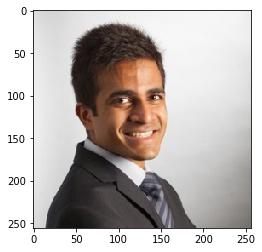

In [5]:
# original image
plt.imshow(image, cmap='gray')

### Create Grid grayscale:

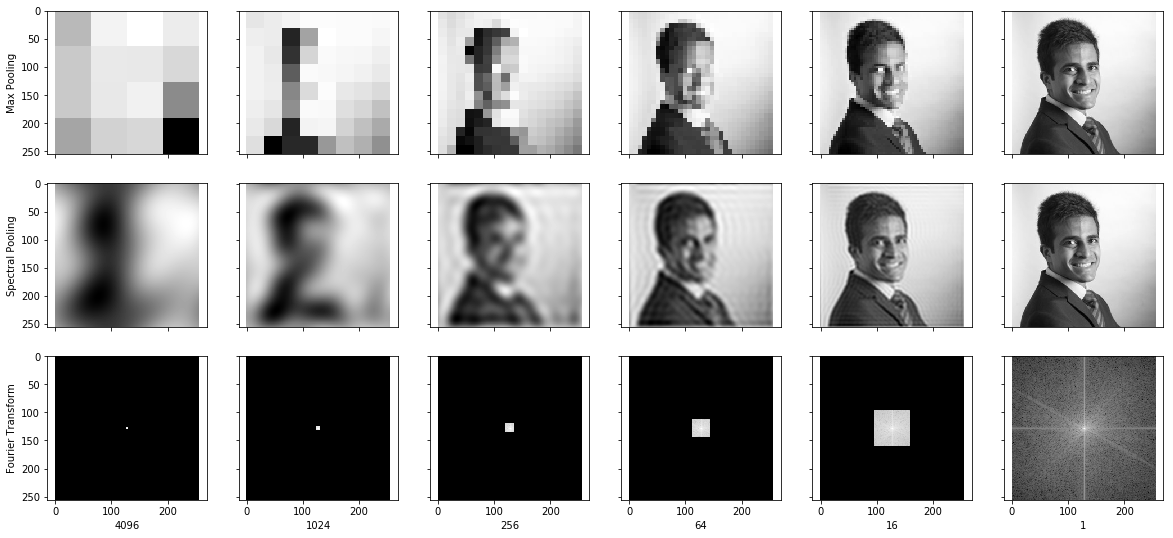

In [8]:
fig, axes = plt.subplots(3, 6, figsize=(20, 9), sharex=True, sharey=True)
pool_size = [64, 32, 16, 8, 4, 1]

for i in range(6):
    ax = axes[0, i]
    im_pool = max_pool(image, pool_size=pool_size[i])
    im_pool = np.squeeze(im_pool)
    ax.imshow(im_pool, cmap='gray')
#     ax.set_xlabel(pool_size[i])
    if not i:
        ax.set_ylabel('Max Pooling')

for i in range(6):
    ax = axes[1, i]
    ax2 = axes[2, i]
    im_fft, im_pool = spectral_pool(image, pool_size=pool_size[i])
    im_pool = np.squeeze(im_pool)
    ax.imshow(im_pool, cmap='gray')
    ax2.imshow(get_fft_plot(im_fft), cmap='gray')
    ax2.set_xlabel(pool_size[i]**2)
    if not i:
        ax.set_ylabel('Spectral Pooling')
        ax2.set_ylabel('Fourier Transform')

### Create Grid RGB:

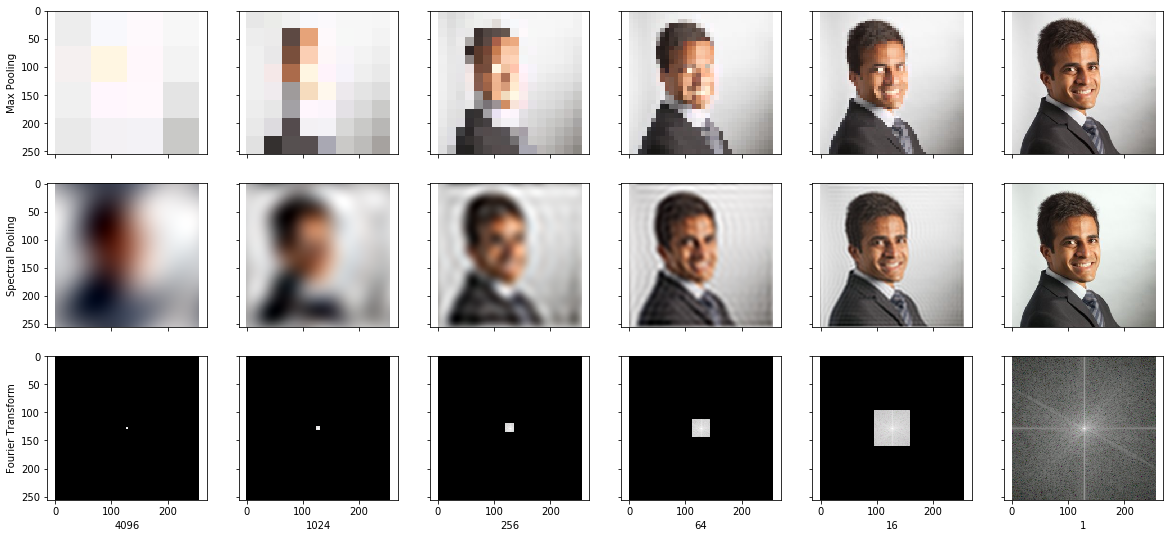

In [7]:
fig, axes = plt.subplots(3, 6, figsize=(20, 9), sharex=True, sharey=True)
pool_size = [64, 32, 16, 8, 4, 1]

for i in range(6):
    ax = axes[0, i]
    im_pool = max_pool(image, pool_size=pool_size[i], convert_grayscale=False)
    im_pool = np.squeeze(im_pool)
    ax.imshow(im_pool, cmap='gray')
#     ax.set_xlabel(pool_size[i])
    if not i:
        ax.set_ylabel('Max Pooling')

for i in range(6):
    ax = axes[1, i]
    ax2 = axes[2, i]
    im_fft, im_pool = spectral_pool(image, pool_size=pool_size[i], convert_grayscale=False)
    im_pool = np.squeeze(im_pool)
    ax.imshow(im_pool)
    ax2.imshow(get_fft_plot(im_fft))
    ax2.set_xlabel(pool_size[i]**2)
    if not i:
        ax.set_ylabel('Spectral Pooling')
        ax2.set_ylabel('Fourier Transform')